# Setup

In [12]:
import numpy as np
from prondict import getIsolated
import lab2_proto as proto
import lab2_tools as tools
import matplotlib.pyplot as plt
data_raw = np.load('lab2_data.npz', allow_pickle=True)['data']

example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
phoneHMMs_fem = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

isolated = getIsolated()


# 5.1 Gaussian emission probabilities

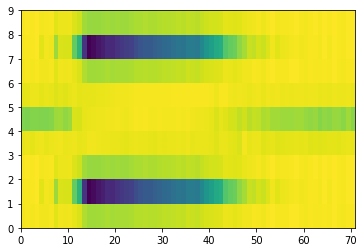

In [13]:
wordHMMs = {}
wordHMMs['o'] = proto.concatHMMs(phoneHMMs_fem, isolated['o'])
obsloglik = tools.log_multivariate_normal_density_diag(example['lmfcc'],wordHMMs['o']["means"],wordHMMs['o']["covars"])

if not np.allclose(obsloglik,example['obsloglik']):
        raise Exception("obsloglik broken")

plt.pcolormesh(obsloglik.T)
plt.show()